<a href="https://colab.research.google.com/github/nazaninaslani/TimeSeries-Demand-Prediction/blob/main/FinalSarimaDemandForecaste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patient Demand Forecast in Family Health Team

# Background

## Project goal

In [ ]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import itertools
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'
import seaborn as sns
from datetime import datetime, timedelta

In [53]:
# Load specific statistical tool for outlier detection
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.stattools import medcouple
import math

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
import pmdarima
from pmdarima import auto_arima                              # for determining ARIMA orders
#normalizing input & output features
from sklearn.preprocessing import MinMaxScaler
#tools for evaluating the forecasting model
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
##
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

#Datasets

In [5]:
Demand = pd.read_csv('DailyDemand.csv')
print(Demand.head())
len(Demand)

   Unnamed: 0  Provider Id  ... Appointment Type  Doctor Id
0           0          128  ...       non-urgent         38
1           1           94  ...       non-urgent         37
2           3          114  ...       non-urgent         16
3           4           25  ...           urgent         21
4           5          144  ...           urgent         26

[5 rows x 6 columns]


40754

# Pipline for handling missing values & cleaning dataset

In [6]:
def clean_data (df_in,col_1,col_2,val_2,col_3,val_3,col_4,val_4):
  #Removing the missing values
  df_in.dropna(subset=[col_1], inplace = True)
  #Removing records with negative access time
  df_in = df_in[df_in[col_1]>=0]
  #
  df_in = df_in[df_in[col_3] == val_3]
  #Specific app type
  df_in = df_in[df_in[col_2] == val_2]
  #Handling the categorial variable
  df_in[col_2] = np.where(df_in[col_2]== val_2,1,0)
  df_in['CareContinuity'] = np.where((df_in[col_4]==val_4),1,0 )
  return df_in

In [7]:
Demand = clean_data(Demand,'Wait Interval','Appointment Type','urgent','Doctor Id',32,'Provider Id',96)

In [8]:
Demand

,Unnamed: 0,Provider Id,Booking Date,Wait Interval,Appointment Type,Doctor Id,CareContinuity
92,130,96,30-Aug-17,1.0,1,32,1
104,149,96,31-Aug-17,0.0,1,32,1
112,158,96,29-Aug-17,2.0,1,32,1
123,172,96,29-Aug-17,2.0,1,32,1
225,371,95,24-Aug-17,11.0,1,32,0
...,...,...,...,...,...,...,...
40676,60566,96,24-Aug-18,6.0,1,32,1
40679,60570,95,31-Aug-18,0.0,1,32,0
40681,60574,96,29-Aug-18,1.0,1,32,1
40688,60583,95,31-Aug-18,0.0,1,32,0


#Pipline for handling the outliers

In [9]:
def Outlier_handle(df_in, col_name):
  
  #Calculating Medcouple for adjusted boxplot
  
  MC = medcouple(df_in[col_name])
  
  #Calculating IQR
  Q1 = df_in[col_name].quantile(0.25)
  Q3 = df_in[col_name].quantile(0.75)
  IQR = Q3 - Q1
  
  #print(IQR)
  
  #Removing outliers through defining adjusted boxplot based on medcouple function for skewed distribution
  
  q1 = df_in[col_name].quantile(0.25)
  q3 = df_in[col_name].quantile(0.75)
  IQR = q3-q1 #Interquartile range
  fence_low  = q1-1.5*math.exp(-3.5*MC)*IQR
  fence_high = q3+1.5*math.exp(-3.5*MC)*IQR
  df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
  
  return df_out

In [10]:
Demand = Outlier_handle(Demand,'Wait Interval')

In [ ]:
Demand

,Unnamed: 0,Provider Id,Booking Date,Wait Interval,Appointment Type,Doctor Id,CareContinuity
92,130,96,30-Aug-17,1.0,1,32,1
104,149,96,31-Aug-17,0.0,1,32,1
112,158,96,29-Aug-17,2.0,1,32,1
123,172,96,29-Aug-17,2.0,1,32,1
225,371,95,24-Aug-17,11.0,1,32,0
...,...,...,...,...,...,...,...
40676,60566,96,24-Aug-18,6.0,1,32,1
40679,60570,95,31-Aug-18,0.0,1,32,0
40681,60574,96,29-Aug-18,1.0,1,32,1
40688,60583,95,31-Aug-18,0.0,1,32,0


# Pipline for preprocessing the timeSeries data & creating new features 


In [11]:
def preprocess_df (df_in,col_date,col_feature1,col_feature2):
  
  #df_in = df_in[['Booking Date', 'Appointment Type','Doctor Id']]
  df_in = df_in.loc[:,[col_date,col_feature1,col_feature2]]
  #Converting object into datetime for booking date
  df_in[col_date] = pd.to_datetime(df_in[col_date])
  #Sorting based on booking date
  df_in = df_in.sort_values(by=col_date,ascending=True)
  #Calculating total demand per day for a specific doctor
  df_in = df_in.groupby(by=[col_date], as_index=False).aggregate(pd.np.sum)
  #Changing the name of the feature column
  df_in.rename(columns= {col_feature1:'Urgent Daily Demand'}, inplace= True)
  df_in.set_index(col_date, inplace=True)
  df_in = df_in.asfreq('D')
  df_in.reset_index(inplace=True)
  #adding a feature for continuity of care
  #df_in['CareContinuity'] = np.where((df_in[col_feature1]==96),1,0 )
  #adding a feature for days of a week
  df_in['Weekday'] = df_in[col_date].dt.day_name()
  #Since the original booking dates in the dataset is due to the existence of demand, after creating a daily based time series, daily demand for the booking dates which are not in the original dataset is Null value. So the Null values are replaced with zero replacing the null values with zero
  df_in['Urgent Daily Demand'] = df_in['Urgent Daily Demand'].fillna(0)
  df_in['CareContinuity'] = df_in['CareContinuity'].fillna(0)
  #adding feature for each day of a week
  df_in['Monday'] =  np.where(df_in['Weekday']=='Monday',1,0)
  df_in['Tuesday'] = np.where(df_in['Weekday']=='Tuesday',1,0)
  df_in['Wednesday'] = np.where(df_in['Weekday']=='Wednesday',1,0)
  df_in['Thursday'] = np.where(df_in['Weekday']=='Thursday',1,0)
  df_in['Friday'] = np.where(df_in['Weekday']=='Friday',1,0)
  df_in.set_index('Booking Date', inplace=True)

  return df_in

In [12]:
Demand = preprocess_df(Demand,'Booking Date','Appointment Type','CareContinuity')

In [13]:
Demand

,Urgent Daily Demand,CareContinuity,Weekday,Monday,Tuesday,Wednesday,Thursday,Friday
Booking Date,,,,,,,,
2017-08-24,1.0,0.0,Thursday,0,0,0,1,0
2017-08-25,0.0,0.0,Friday,0,0,0,0,1
2017-08-26,0.0,0.0,Saturday,0,0,0,0,0
2017-08-27,0.0,0.0,Sunday,0,0,0,0,0
2017-08-28,0.0,0.0,Monday,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2018-08-27,6.0,1.0,Monday,1,0,0,0,0
2018-08-28,2.0,2.0,Tuesday,0,1,0,0,0
2018-08-29,4.0,2.0,Wednesday,0,0,1,0,0


#Plot the source data

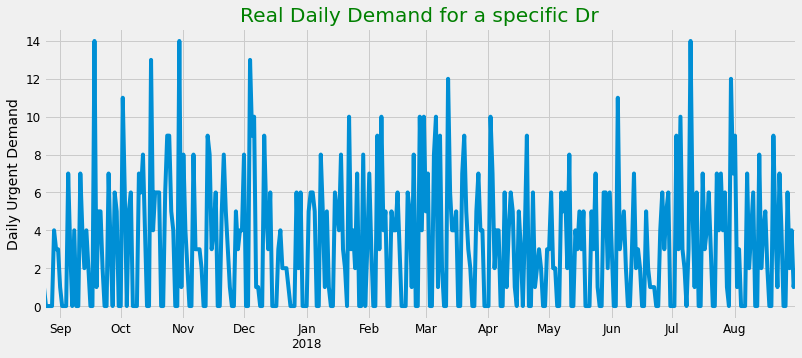

In [14]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Daily Demand for a specific Dr'
ylabel='Daily Urgent Demand'
xlabel='' # we don't really need a label here

ax = Demand['Urgent Daily Demand'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Run an ETS Decomposition

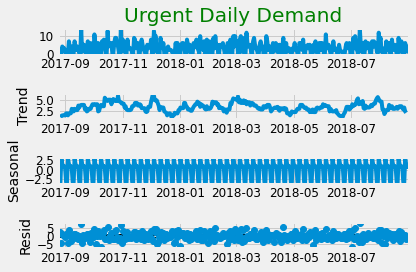

In [15]:
result = seasonal_decompose(Demand['Urgent Daily Demand'])
result.plot();

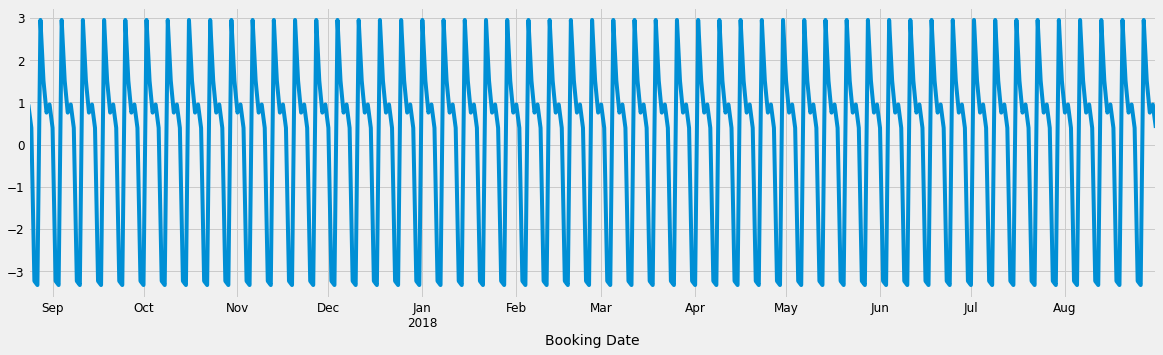

In [16]:
#result.trend.plot(figsize=(18,5))
result.seasonal.plot(figsize=(18,5))
#result.resid.plot(figsize=(18,5));

Due to the presence of seasonality, SARIMA is used as a forecasting model

#Building the model

**Step 1:** spliting the dataset into train/test sets


In [17]:
def train_test_split(df_in, train_prop):
  train_size=int(len(df_in) *train_prop)
  test_size = int(len(df_in)) - train_size
  
  return df_in[:-test_size], df_in[-test_size:]

In [18]:
trainset, testset = train_test_split(Demand, 0.7)

In [19]:
trainset

,Urgent Daily Demand,CareContinuity,Weekday,Monday,Tuesday,Wednesday,Thursday,Friday
Booking Date,,,,,,,,
2017-08-24,1.0,0.0,Thursday,0,0,0,1,0
2017-08-25,0.0,0.0,Friday,0,0,0,0,1
2017-08-26,0.0,0.0,Saturday,0,0,0,0,0
2017-08-27,0.0,0.0,Sunday,0,0,0,0,0
2017-08-28,0.0,0.0,Monday,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2018-05-07,6.0,4.0,Monday,1,0,0,0,0
2018-05-08,5.0,4.0,Tuesday,0,1,0,0,0
2018-05-09,6.0,3.0,Wednesday,0,0,1,0,0


In [20]:
testset

,Urgent Daily Demand,CareContinuity,Weekday,Monday,Tuesday,Wednesday,Thursday,Friday
Booking Date,,,,,,,,
2018-05-12,0.0,0.0,Saturday,0,0,0,0,0
2018-05-13,0.0,0.0,Sunday,0,0,0,0,0
2018-05-14,4.0,3.0,Monday,1,0,0,0,0
2018-05-15,3.0,1.0,Tuesday,0,1,0,0,0
2018-05-16,5.0,2.0,Wednesday,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2018-08-27,6.0,1.0,Monday,1,0,0,0,0
2018-08-28,2.0,2.0,Tuesday,0,1,0,0,0
2018-08-29,4.0,2.0,Wednesday,0,0,1,0,0


**Step 2:** finding initial parameters for SARIMA model

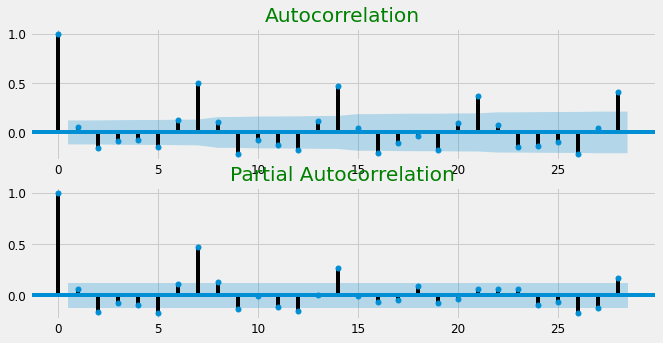

In [21]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(trainset['Urgent Daily Demand'], lags=28, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(trainset['Urgent Daily Demand'], lags=28, ax=ax[1])
plt.show()

Since both ACF and PACF presents significant lags in weekly seasonal pattern, I took the difference of demand values

In [22]:
# create a differenced series
def difference(df_in, interval=1):
	diff = list()
	for i in range(interval, len(df_in)):
		value = df_in[i] - df_in[i - interval]
		diff.append(value)
	return np.array(diff)

In [23]:
# invert differenced value
def inverse_difference(history, yhat, interval):
	return yhat + history[-interval]

In [24]:
ydiff = trainset['Urgent Daily Demand'].values
daysinweek = 7
differenced = difference(ydiff, daysinweek)

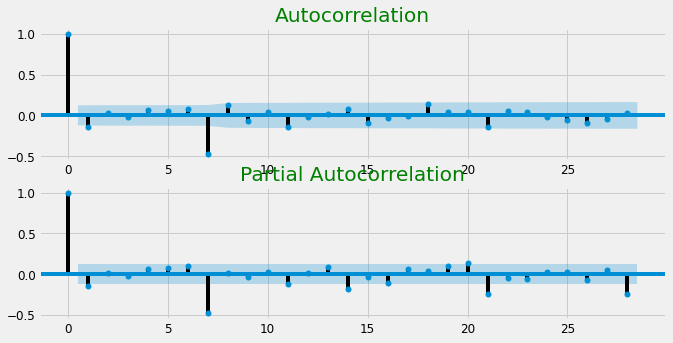

In [25]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(differenced, lags=28, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(differenced, lags=28, ax=ax[1])
plt.show()



1.   ACF plot shows significant lags to 1 time step and 7 time steps
2.   PACF plot shows signiant lags at 1 time step and 7,14,21 time steps
3.   Therefore as start point we start with SARIMA (1,0,0)(2,1,1)[7]



**Step3:** training the model

In [28]:
model= SARIMAX(trainset['Urgent Daily Demand'],order=(1,0,1),seasonal_order=(2,1,1,7),
 enforce_invertibility=False, enforce_stationarity=False)
#Fiting the model
results= model.fit()
train_size=int(len(Demand) *0.7)
test_size = int(len(Demand)) - train_size
#Forecasting
forecast_sarima= results.forecast(steps=test_size)
forecast_sarima

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2018-05-12    0.309208
2018-05-13   -0.217313
2018-05-14    7.194307
2018-05-15    4.465190
2018-05-16    4.628198
                ...   
2018-08-27    7.014747
2018-08-28    4.644401
2018-08-29    4.353239
2018-08-30    4.259882
2018-08-31    3.888750
Freq: D, Name: predicted_mean, Length: 112, dtype: float64

**Step 4:**Time Series Cross Validation (Walk forward approach)

predicted=-0.084270, expected=0.000000
predicted=0.168827, expected=0.000000
predicted=6.423213, expected=4.000000
predicted=4.920028, expected=3.000000
predicted=4.369773, expected=5.000000
predicted=3.962740, expected=3.000000
predicted=4.137231, expected=5.000000
predicted=0.165640, expected=0.000000
predicted=-0.068336, expected=0.000000
predicted=6.330256, expected=0.000000
predicted=4.530761, expected=5.000000
predicted=4.310774, expected=3.000000
predicted=4.070814, expected=7.000000
predicted=3.726332, expected=1.000000
predicted=0.473778, expected=0.000000
predicted=-0.342697, expected=0.000000
predicted=5.866875, expected=6.000000
predicted=4.379534, expected=6.000000
predicted=4.330460, expected=2.000000
predicted=4.415534, expected=6.000000
predicted=3.408075, expected=3.000000
predicted=0.034724, expected=0.000000
predicted=0.049578, expected=0.000000
predicted=6.323838, expected=11.000000
predicted=4.733248, expected=3.000000
predicted=4.127536, expected=4.000000
predicte

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=5.488307, expected=1.000000
predicted=3.742367, expected=6.000000
predicted=0.080848, expected=0.000000
predicted=0.155526, expected=0.000000
predicted=5.495707, expected=7.000000
predicted=6.170976, expected=3.000000
predicted=4.462642, expected=4.000000
predicted=3.794961, expected=6.000000
predicted=3.764299, expected=3.000000
predicted=0.275102, expected=0.000000
predicted=-0.029617, expected=0.000000
predicted=6.212369, expected=7.000000
predicted=4.783610, expected=4.000000
predicted=4.162640, expected=7.000000
predicted=4.104634, expected=4.000000
predicted=3.731515, expected=6.000000
predicted=-0.149276, expected=1.000000
predicted=0.014014, expected=0.000000
predicted=6.290549, expected=12.000000
predicted=4.253824, expected=7.000000
predicted=4.436754, expected=9.000000
predicted=3.885390, expected=1.000000
predicted=4.377507, expected=3.000000
predicted=0.150200, expected=0.000000
predicted=0.058479, expected=0.000000
predicted=6.976101, expected=0.000000
predicted

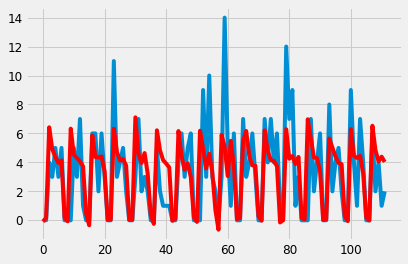

In [30]:
history = [x for x in trainset['Urgent Daily Demand']]
test = testset['Urgent Daily Demand'].values
predictions = list()
for t in range(len(test)):
  model = SARIMAX(history, order=(1,0,1),seasonal_order=(2,1,1,7))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append((yhat))
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
error3 = rmse((test), (predictions))
print('SARIMA(1,0,1)(2,1,1)[7] MAE Error: %.3f' %error1)
print('SARIMA(1,0,1)(2,1,1)[7] MSE Error: %.3f' %error2)
print('SARIMA(1,0,1)(2,1,1)[7] RMSE Error: %.3f'%error3)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

In [31]:
def retrive_cum_rmse(test,predict):
    """Reterive the cumulative Root Mean Square Error between a test dataset and real values.
    """
    cum_err = np.cumsum(np.sqrt((test - predict)**2))
    for i in range(len(cum_err)):
        cum_err[i] /= i+1
    return cum_err

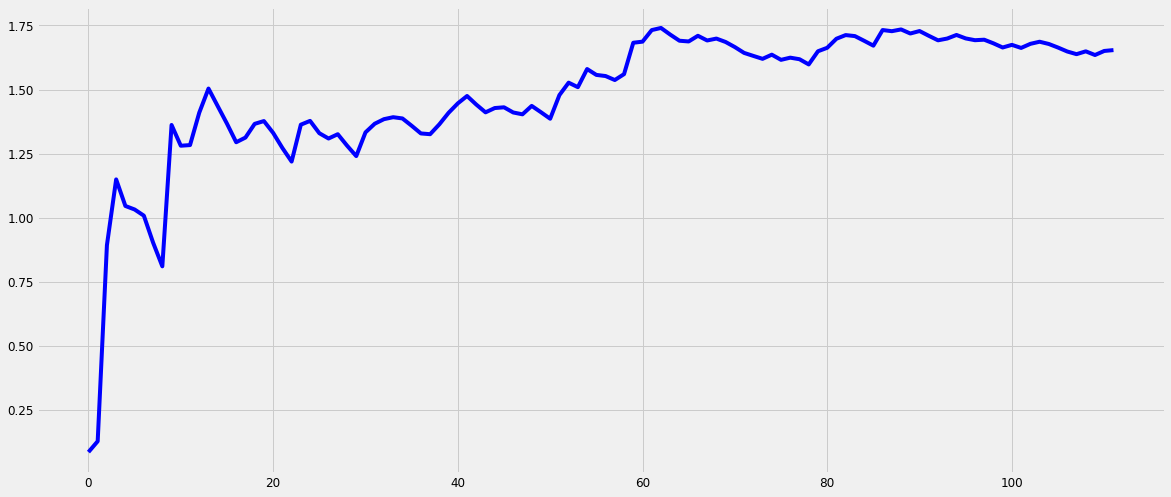

In [33]:
Sarimaerr = retrive_cum_rmse(test,predictions)
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(Sarimaerr, 'b', label='Sarima')

**Step5:** Improving the model (Grid search)

Creating a set of sarima configs to try

In [34]:
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [1, 2]
	D_params = [1]
	Q_params = [1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,0,q), (1,1,1,7), 'n']
									models.append(cfg)
	return models


In [36]:
# model configs
cfg_list = sarima_configs()
cfg_list

[[(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 0), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1), (1, 1, 1, 7), 'n'],
 [(0, 0, 1

In [37]:
#One step SARIMA forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [38]:
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [39]:
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [40]:
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [41]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [42]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [46]:
Demand

,Urgent Daily Demand,CareContinuity,Weekday,Monday,Tuesday,Wednesday,Thursday,Friday
Booking Date,,,,,,,,
2017-08-24,1.0,0.0,Thursday,0,0,0,1,0
2017-08-25,0.0,0.0,Friday,0,0,0,0,1
2017-08-26,0.0,0.0,Saturday,0,0,0,0,0
2017-08-27,0.0,0.0,Sunday,0,0,0,0,0
2017-08-28,0.0,0.0,Monday,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2018-08-27,6.0,1.0,Monday,1,0,0,0,0
2018-08-28,2.0,2.0,Tuesday,0,1,0,0,0
2018-08-29,4.0,2.0,Wednesday,0,0,1,0,0


In [47]:
df_demand = Demand[['Urgent Daily Demand']]

In [49]:
df_demand.to_csv('df_demand.csv', header=False)

In [51]:
#load data
series = pd.read_csv('df_demand.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
#prepare data
data = series.values
data = data.astype('float32')
n_test = int(len(data)*0.70)

In [ ]:
# grid search
scores = grid_search(data, cfg_list, n_test)

 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.382
 > Model[[(0, 0, 1), (1, 1, 1, 7), 'n']] 2.377
 > Model[[(0, 0, 1), (1, 1, 1, 7), 'n']] 2.377
 > Model[[(0, 0, 1), (1, 1, 1, 7), 'n']] 2.377
 > Model[[(0, 0, 1), (1, 1, 1, 7), 'n']] 2.377
 > Model[[(0, 0, 1), (1, 1, 1, 7), 'n']] 2.377
 > Model[[(0,

In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

predicted=-0.005985, expected=0.000000
predicted=0.012099, expected=0.000000
predicted=0.458818, expected=0.285714
predicted=0.351431, expected=0.214286
predicted=0.312107, expected=0.357143
predicted=0.283040, expected=0.214286
predicted=0.295103, expected=0.357143
predicted=0.011834, expected=0.000000
predicted=-0.004877, expected=0.000000
predicted=0.452181, expected=0.000000
predicted=0.323687, expected=0.357143
predicted=0.307903, expected=0.214286
predicted=0.290792, expected=0.500000
predicted=0.266165, expected=0.071429
predicted=0.033837, expected=0.000000
predicted=-0.024494, expected=0.000000
predicted=0.419066, expected=0.428571
predicted=0.312821, expected=0.428571
predicted=0.309321, expected=0.142857
predicted=0.315396, expected=0.428571
predicted=0.243433, expected=0.214286
predicted=0.002480, expected=0.000000
predicted=0.003537, expected=0.000000
predicted=0.451694, expected=0.785714
predicted=0.338071, expected=0.214286
predicted=0.294819, expected=0.285714
predicted

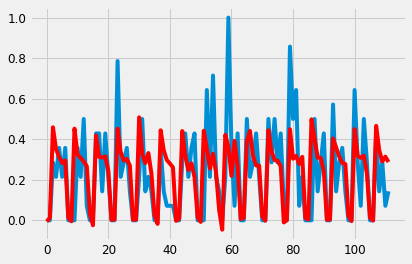

In [ ]:
#walk foreward
testX = test_X['Wednesday'].values
testX = testX.astype('float32')
test = test_y['Urgent Daily Demand'].values
test = test.astype('float32')


history = [j for j in train_y['Urgent Daily Demand']]
exg1 = [i for i in train_X['Wednesday']]
predictions = list()
for t in range(len(test_y)):
  exgtest1 = [i for i in test_X['Wednesday']]
  model = SARIMAX(history,exog=exg1, order=(1,0,1),seasonal_order=(2,1,1,7),enforce_invertibility=True, enforce_stationarity=True)
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast(steps=1, exog=exgtest1[t])
  yhat = output[0]
  predictions.append((yhat))
  obs = test[t]
  obsex = testX[t]
  history.append(obs)
  exg1.append(obsex)

  #test_size -=1
  print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
print('ARIMA(1,0,1)(2,1,0)[7] MAE Error: %.3f' %error1)
print('ARIMA(1,0,1)(2,1,0)[7] MSE Error: %.3f' %error2)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
#walk foreward Sarima
#testX = test_X['Monday'].values
#testX = testX.astype('float32')
test = test_y['Urgent Daily Demand'].values
test = test.astype('float32')


history = [j for j in train_y['Urgent Daily Demand']]
#exg1 = [i for i in train_X['Monday']]
predictions2 = list()
for t in range(len(test_y)):
  #exgtest1 = [i for i in test_X['Monday']]
  model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,1,7),enforce_invertibility=True, enforce_stationarity=True)
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions2.append((yhat))
  obs = test[t]
  #obsex = testX[t]
  history.append(obs)
  #exg1.append(obsex)

  #test_size -=1
  print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
print('ARIMA(1,0,1)(2,1,0)[7] MAE Error: %.3f' %error1)
print('ARIMA(1,0,1)(2,1,0)[7] MSE Error: %.3f' %error2)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
def walk_forward_validation(df_in, train_prop,X,colX,Y,colY):
  
  predictions = list()
  # split dataset
  train_X,train_y,test_X,test_y = train_test_split(df_in,train_prop,X,Y)
  test = test_y[colY].values
  test = test.astype('float32')

  # seed history with training dataset
  history = [j for j in train_y[colY]]
  
  #history = [j for j in train_y['Urgent Daily Demand']]
  exg1 = [i for i in train_X[colX]]
  #exg1 = [i for i in train_X['Wednesday']]
  
  # step over each time-step in the test set
  for t in range(len(test_y)):
    exgtest1 = [i for i in test_X[colX]]
    model = SARIMAX(history,exog=exg1, order=(1,0,1),seasonal_order=(2,1,1,7),enforce_invertibility=True, enforce_stationarity=True)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1, exog=exgtest1[t])
    yhat = output[0]
    predictions.append((yhat))
    obs = test[t]
    obsex = test_X[t]
    history.append(obs)
    exg1.append(obsex)
    #print('predicted=%f, expected=%f' % ((yhat), (obs)))
  
  return predictions

In [ ]:
#error1 = mean_absolute_error(test, predictions)
  #error2 = mean_squared_error(test, predictions)
  #error = measure_rmse(test, predictions)
  #print('ARIMA(1,0,1)(2,1,0)[7] MAE Error: %.3f' %error1)
  #print('ARIMA(1,0,1)(2,1,0)[7] MSE Error: %.3f' %error2)

In [ ]:
Demand.columns

Index(['Urgent Daily Demand', 'CareContinuity', 'Weekday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday'],
      dtype='object')

In [ ]:
walk_forward_validation(Demand, 0.7,X,'Wednesday',Y,'Urgent Daily Demand')

KeyError: ignored

In [ ]:
# plot
  pyplot.plot((test))
  pyplot.plot(predictions, color='red')
  pyplot.show()

predicted=-0.084217, expected=0.000000
predicted=0.168846, expected=0.000000
predicted=6.423208, expected=4.000000
predicted=4.920026, expected=3.000000
predicted=4.369743, expected=5.000000
predicted=3.962744, expected=3.000000
predicted=4.137260, expected=5.000000
predicted=0.165679, expected=0.000000
predicted=-0.068331, expected=0.000000
predicted=6.330231, expected=0.000000
predicted=4.530705, expected=5.000000
predicted=4.310822, expected=3.000000
predicted=4.070882, expected=7.000000
predicted=3.726397, expected=1.000000
predicted=0.473754, expected=0.000000
predicted=-0.342699, expected=0.000000
predicted=5.866915, expected=6.000000
predicted=4.379531, expected=6.000000
predicted=4.330451, expected=2.000000
predicted=4.415573, expected=6.000000
predicted=3.408102, expected=3.000000
predicted=0.034712, expected=0.000000
predicted=0.049581, expected=0.000000
predicted=6.323858, expected=11.000000
predicted=4.733344, expected=3.000000
predicted=4.127528, expected=4.000000
predicte

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=4.302410, expected=4.000000
predicted=3.402601, expected=6.000000
predicted=0.024278, expected=0.000000
predicted=0.060413, expected=0.000000
predicted=5.649125, expected=8.000000
predicted=5.023184, expected=2.000000
predicted=4.414816, expected=4.000000
predicted=3.971180, expected=5.000000
predicted=3.880105, expected=2.000000
predicted=0.293304, expected=0.000000
predicted=-0.056018, expected=0.000000
predicted=6.296821, expected=9.000000
predicted=4.452251, expected=4.000000
predicted=4.301532, expected=1.000000
predicted=4.459633, expected=7.000000
predicted=3.238642, expected=4.000000
predicted=0.195073, expected=0.000000
predicted=-0.015313, expected=0.000000
predicted=6.531625, expected=6.000000
predicted=4.843026, expected=2.000000
predicted=4.067418, expected=4.000000
predicted=4.394655, expected=1.000000
predicted=4.028731, expected=2.000000
ARIMA(1,0,1)(2,1,0)[7] MAE Error: 1.654
ARIMA(1,0,1)(2,1,0)[7] MSE Error: 5.653


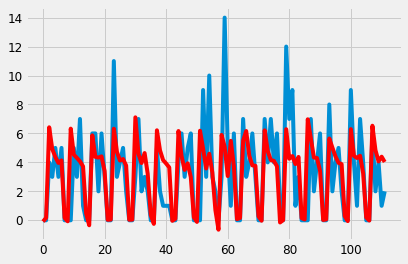

In [ ]:
#walk foreward
testX = test_X['Wednesday'].values
testX = testX.astype('float32')
test = test_y['Urgent Daily Demand'].values
test = test.astype('float32')


history = [j for j in train_y['Urgent Daily Demand']]
exg1 = [i for i in train_X['Wednesday']]
predictions = list()
for t in range(len(test_y)):
  exgtest1 = [i for i in test_X['Monday']]
  model = SARIMAX(history,exog=exg1, order=(1,0,1),seasonal_order=(2,1,1,7),enforce_invertibility=True, enforce_stationarity=True)
  model_fit = model.fit(disp=0)
  output = model_fit.forecast(steps=1, exog=exgtest1[t])
  yhat = output[0]
  predictions.append((yhat))
  obs = test[t]
  obsex = testX[t]
  history.append(obs)
  exg1.append(obsex)

  #test_size -=1
  print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
print('ARIMA(1,0,1)(2,1,0)[7] MAE Error: %.3f' %error1)
print('ARIMA(1,0,1)(2,1,0)[7] MSE Error: %.3f' %error2)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
def retrive_cum_rmse(test,predict):
    """Reterive the cumulative Root Mean Square Error between a test dataset and real values.
    """
    cum_err = np.cumsum(np.sqrt((test - predict)**2))
    for i in range(len(cum_err)):
        cum_err[i] /= i+1
    return cum_err

In [ ]:
Sarimaxerr = retrive_cum_rmse(test,predictions)

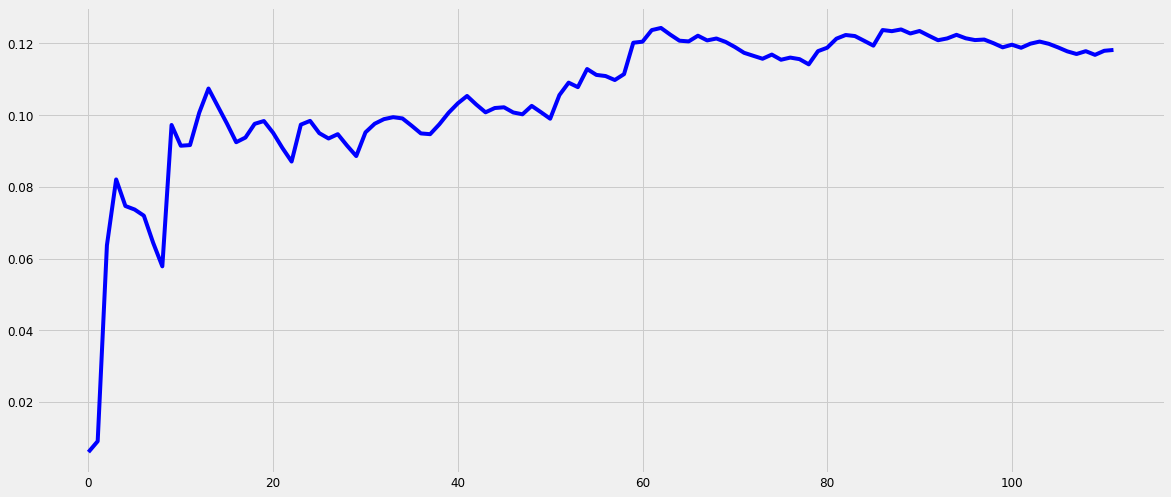

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(Sarerr, 'b', label='Sarimax')

predicted=-0.006147, expected=0.000000
predicted=0.012083, expected=0.000000
predicted=0.458784, expected=0.285714
predicted=0.351414, expected=0.214286
predicted=0.312127, expected=0.357143
predicted=0.283039, expected=0.214286
predicted=0.295511, expected=0.357143
predicted=0.011816, expected=0.000000
predicted=-0.004881, expected=0.000000
predicted=0.452066, expected=0.000000
predicted=0.323618, expected=0.357143
predicted=0.307924, expected=0.214286
predicted=0.290776, expected=0.500000
predicted=0.266189, expected=0.071429
predicted=0.033853, expected=0.000000
predicted=-0.024451, expected=0.000000
predicted=0.419080, expected=0.428571
predicted=0.312826, expected=0.428571
predicted=0.309322, expected=0.142857
predicted=0.315395, expected=0.428571
predicted=0.243426, expected=0.214286
predicted=0.002482, expected=0.000000
predicted=0.003543, expected=0.000000
predicted=0.451700, expected=0.785714
predicted=0.338091, expected=0.214286
predicted=0.294829, expected=0.285714
predicted

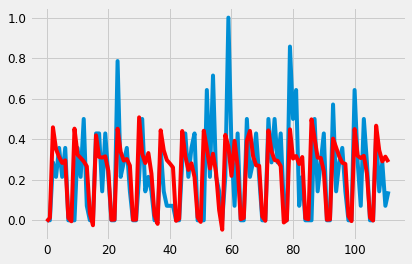

In [ ]:
#walk foreward Sarima
#testX = test_X['Monday'].values
#testX = testX.astype('float32')
test = test_y['Urgent Daily Demand'].values
test = test.astype('float32')


history = [j for j in train_y['Urgent Daily Demand']]
#exg1 = [i for i in train_X['Monday']]
predictions2 = list()
for t in range(len(test_y)):
  #exgtest1 = [i for i in test_X['Monday']]
  model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,1,7),enforce_invertibility=True, enforce_stationarity=True)
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions2.append((yhat))
  obs = test[t]
  #obsex = testX[t]
  history.append(obs)
  #exg1.append(obsex)

  #test_size -=1
  print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
print('ARIMA(1,0,1)(2,1,0)[7] MAE Error: %.3f' %error1)
print('ARIMA(1,0,1)(2,1,0)[7] MSE Error: %.3f' %error2)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
Sarimaerr = retrive_cum_rmse(test,predictions2)

Comparision

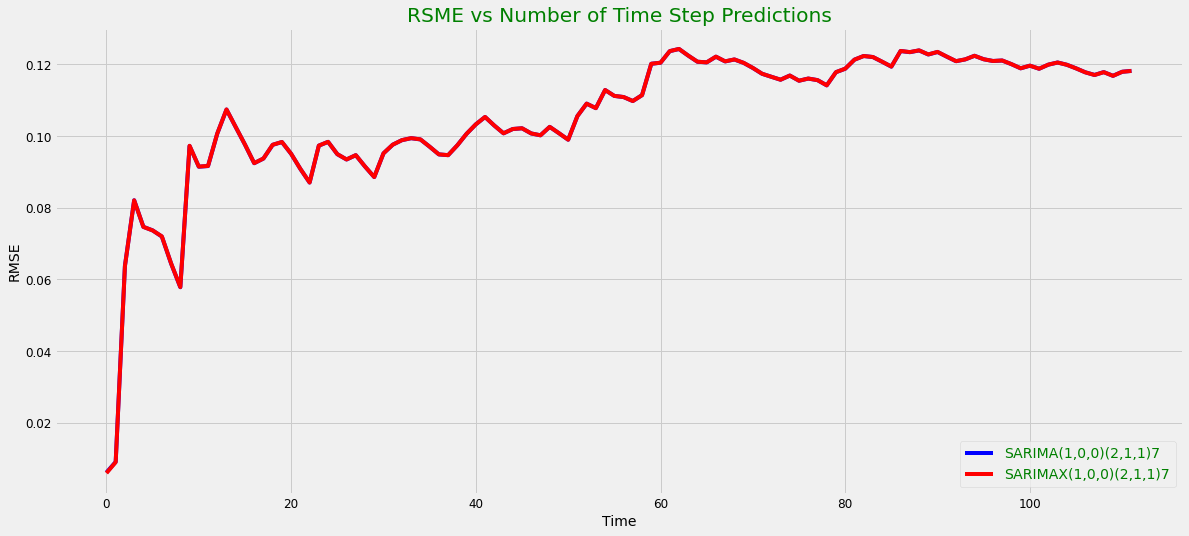

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
npre = 4
ax.set(title='RSME vs Number of Time Step Predictions', xlabel='Time', ylabel='RMSE')
ax.plot(Sarimaerr, 'b', label='SARIMA(1,0,0)(2,1,1)7')
ax.plot(Sarimaxerr, 'r', label='SARIMAX(1,0,0)(2,1,1)7')

#ax.set_ylim(bottom=0, top=1000)
#ax.set_xlim(left=0, right=29)

legend = ax.legend(loc='lower right')

#Plot the Source Data

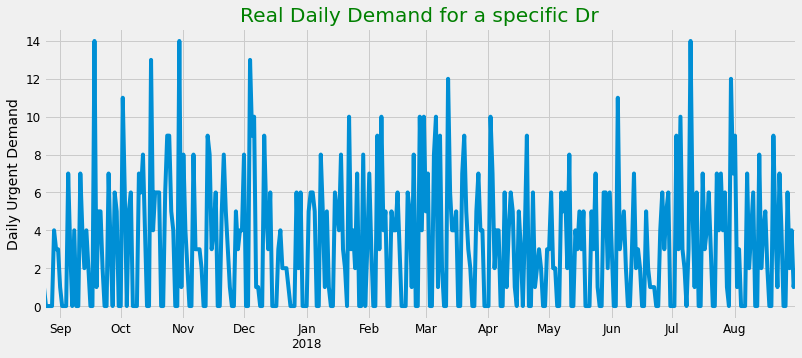

In [ ]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Daily Demand for a specific Dr'
ylabel='Daily Urgent Demand'
xlabel='' # we don't really need a label here

ax = Demand['Urgent Daily Demand'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Run an ETS Decomposition

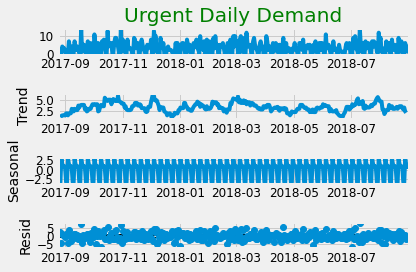

In [ ]:
result = seasonal_decompose(Demand['Urgent Daily Demand'])
result.plot();

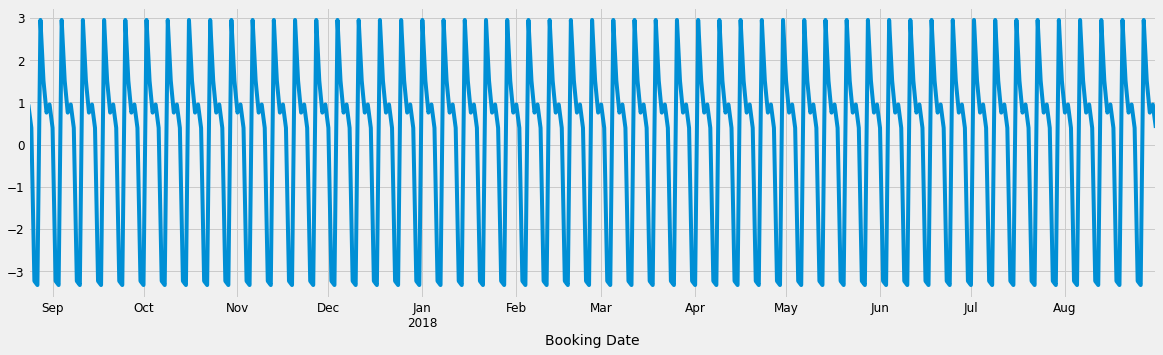

In [ ]:
#result.trend.plot(figsize=(18,5))
result.seasonal.plot(figsize=(18,5))
#result.resid.plot(figsize=(18,5));

In [ ]:
Demand.dtypes

Urgent Daily Demand    float64
dtype: object

In [ ]:
len(Demand)

373

In [ ]:
Demand.head()

,Urgent Daily Demand
Booking Date,
2017-08-24,1.0
2017-08-25,0.0
2017-08-26,0.0
2017-08-27,0.0
2017-08-28,0.0


# Split Dataset

In [ ]:
Demand.to_csv('UrgentDemand.csv')
#split into a traiining and test dataset
series = pd.read_csv('UrgentDemand.csv', index_col=0, header=0, parse_dates=True, squeeze=True)
split_point = len(series) - 7
dataset, testset = series[0:split_point], series[split_point:]

print('Dataset %d, validation %d' % (len(dataset), len(testset)))
dataset.to_csv('DataSet.csv', header=False)
testset.to_csv('TestSet.csv', header=False)

Dataset 366, validation 7


# Grid search sarima hyperparameters

In [ ]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

One Step Sarima Forecast

In [ ]:
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

root mean squared error or rmse

In [ ]:
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

split a univariate dataset into train/test sets

In [ ]:
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

walk-forward validation for univariate data

In [ ]:
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

create a set of sarima configs to try

In [ ]:
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,0,q), (1,1,1,7), 'n']
									models.append(cfg)
	return models


In [ ]:
#load data
series = pd.read_csv('DataSet.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
#prepare data
data = series.values
data = data.astype('float32')
n_test = int(len(data)*0.50)
#trainSet, testSet = X[0:train_size], X[train_size:]
#####
#history = [x for x in train]


In [ ]:
# model configs
cfg_list = sarima_configs()

In [ ]:
cfg_list

In [ ]:
# grid search
scores = grid_search(data, cfg_list, n_test)

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 4.641
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 3.184
 > Model[[(0, 0, 0), (0, 0, 0, 0), 't']] 3.643
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 4.126
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'ct']] 3.204
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'c']] 3.188
 > Model[[(0, 0, 1), (0, 0, 0, 0), 't']] 3.535
 > Model[[(0, 0, 2), (0, 0, 0, 0), 'n']] 4.032
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'ct']] 3.207
 > Model[[(0, 0, 2), (0, 0, 0, 0), 'c']] 3.140
 > Model[[(0, 0, 2), (0, 0, 0, 0), 't']] 3.538
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'n']] 4.416
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'c']] 4.425
 > Model[[(0, 1, 0), (0, 0, 0, 0), 't']] 4.442
 > Model[[(0, 0, 2), (0, 0, 0, 0), 'ct']] 3.159
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'ct']] 4.451
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'n']] 3.188
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'c']] 3.204
 > Model[[(0, 1, 1), (0, 0, 0, 0), 't']] 3.217
 > Model[[(0, 1, 2), (0, 0, 0, 0), 'n']] 3.188
 > Model[[(0, 1, 2), (0, 0, 0, 0), 'c']] 3.207
 > Model[

In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

In [ ]:
train, test = train_test_split(data, n_test)

predicted=3.475808, expected=8.000000
predicted=-0.109443, expected=0.000000
predicted=0.004648, expected=0.000000
predicted=5.824516, expected=10.000000
predicted=4.446072, expected=4.000000
predicted=4.494729, expected=10.000000
predicted=3.589257, expected=5.000000
predicted=3.869403, expected=7.000000
predicted=-0.016720, expected=0.000000
predicted=0.003913, expected=0.000000
predicted=6.937741, expected=8.000000
predicted=4.395078, expected=10.000000
predicted=4.914683, expected=1.000000
predicted=4.391872, expected=9.000000
predicted=3.657512, expected=2.000000
predicted=0.234550, expected=0.000000
predicted=0.006825, expected=0.000000
predicted=6.792894, expected=12.000000
predicted=4.738126, expected=6.000000
predicted=4.146773, expected=4.000000
predicted=4.716068, expected=4.000000
predicted=3.553641, expected=5.000000
predicted=-0.003226, expected=0.000000
predicted=0.006245, expected=0.000000
predicted=7.287411, expected=7.000000
predicted=4.840790, expected=9.000000
predi

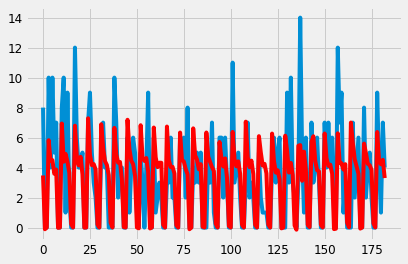

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
  model = SARIMAX(history, order=(1,0,0),seasonal_order=(1,1,1,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append((yhat))
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
print('ARIMA(1,0,1)(2,1,0)[7] MAE Error: %.3f' %error1)
print('ARIMA(1,0,1)(2,1,0)[7] MSE Error: %.3f' %error2)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
2/3

0.6666666666666666

In [ ]:
cum_err = np.cumsum(np.sqrt((test - predict)**2))

for i in range(5):
  cum_err[i] /= i+1
  print(cum_err)

NameError: ignored

In [ ]:
def retrive_cum_rmse(test,predict):
    """Reterive the cumulative Root Mean Square Error between a test dataset and real values.
    """
    cum_err = np.cumsum(np.sqrt((test - predict)**2))
    for i in range(len(cum_err)):
        cum_err[i] /= i+1
    return cum_err

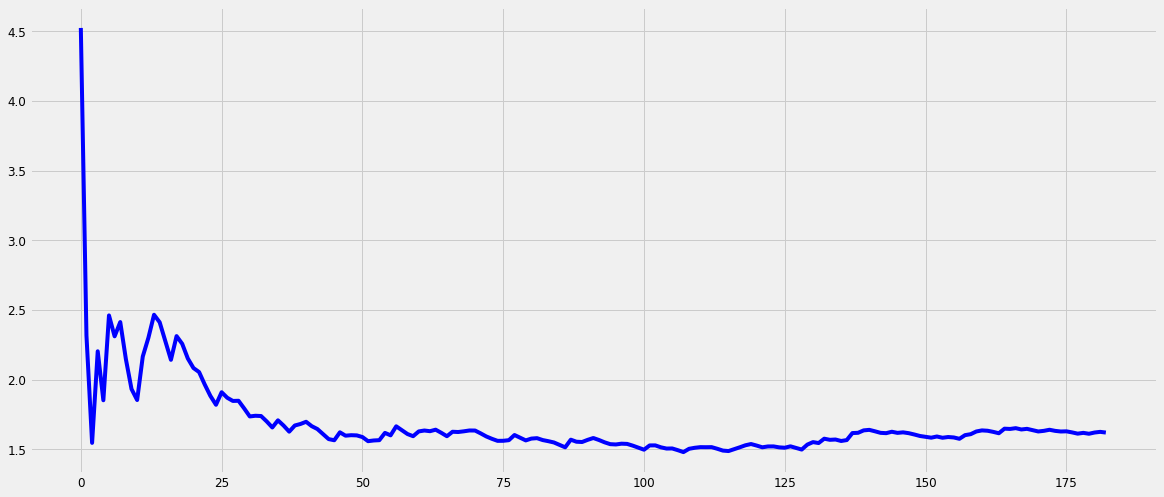

In [ ]:
Sarerr = retrive_cum_rmse(test,predictions)
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(Sarerr, 'b', label='Sarima')

Exogenous variable

In [ ]:
Demand.reset_index(inplace=True)

In [ ]:
Demand

,Booking Date,Urgent Daily Demand,Weekday,month,Tuesday,Wednesday
0,2017-08-24,1.0,Thursday,8,0,0
1,2017-08-25,0.0,Friday,8,0,0
2,2017-08-26,0.0,Saturday,8,0,0
3,2017-08-27,0.0,Sunday,8,0,0
4,2017-08-28,0.0,Monday,8,0,0
...,...,...,...,...,...,...
368,2018-08-27,6.0,Monday,8,0,0
369,2018-08-28,2.0,Tuesday,8,1,0
370,2018-08-29,4.0,Wednesday,8,0,1
371,2018-08-30,1.0,Thursday,8,0,0


In [ ]:
Demand['Weekday'] = Demand['Booking Date'].dt.day_name()

In [ ]:
Demand['month'] = pd.DatetimeIndex(Demand['Booking Date']).month

In [ ]:
Demand['Tuesday'] = np.where(Demand['Weekday']=='Tuesday',1,0)
Demand['Wednesday'] = np.where(Demand['Weekday']=='Wednesday',1,0)

In [ ]:
len(Demand)

373

In [ ]:
len(Demand) - 7

366

In [ ]:
n_test = int(366*0.50)
train1 = Demand.iloc[:n_test]
test1 = Demand.iloc[n_test:366]

In [ ]:
exghistory = [x for x in train1['Wednesday']]

In [ ]:
history = [x for x in train1['Urgent Daily Demand']]
exghistory = [x for x in train1['Wednesday']]
predictions = list()
for t in range(len(test1)):
  model = SARIMAX(history,exog=exghistory, order=(1,0,0),seasonal_order=(1,1,1,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  model_fit = model.fit(disp=0)
  output = model_fit.predict(t,t,exog=exghistory)
  yhat = output[0]
  predictions.append((yhat))
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
print('ARIMA(1,0,1)(2,1,0)[7] MAE Error: %.3f' %error1)
print('ARIMA(1,0,1)(2,1,0)[7] MSE Error: %.3f' %error2)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
history = [x for x in train1['Urgent Daily Demand']]
exghistory = [x for x in train1['Wednesday']]
predictions = list()
for t in range(len(test)):
  model = SARIMAX(history, order=(1,0,0),seasonal_order=(1,1,1,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append((yhat))
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
print('ARIMA(1,0,1)(2,1,0)[7] MAE Error: %.3f' %error1)
print('ARIMA(1,0,1)(2,1,0)[7] MSE Error: %.3f' %error2)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
train = Demand.iloc[:361]
test = Demand.iloc[361:]

Scale Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Time Series Generator

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
scaled_train

array([[0.07142857],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.28571429],
       [0.21428571],
       [0.21428571],
       [0.07142857],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.5       ],
       [0.21428571],
       [0.        ],
       [0.28571429],
       [0.        ],
       [0.        ],
       [0.5       ],
       [0.28571429],
       [0.14285714],
       [0.28571429],
       [0.14285714],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.07142857],
       [0.35714286],
       [0.35714286],
       [0.14285714],
       [0.        ],
       [0.        ],
       [0.5       ],
       [0.21428571],
       [0.        ],
       [0.42857143],
       [0.35714286],
       [0.        ],
       [0.        ],
       [0.78571429],
       [0.42857143],
       [0.        ],
       [0.35714286],
       [0.42857143],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.5  

In [ ]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
len(scaled_train)

361

In [ ]:
len(generator)

359

In [ ]:
generator[0]

(array([[[0.07142857],
         [0.        ]]]), array([[0.]]))

In [ ]:
# What does the first batch look like?
X,y = generator[0]

In [ ]:
X

array([[[0.07142857],
        [0.        ]]])

In [ ]:
X.flatten()

array([0.07142857, 0.        ])

In [ ]:
y

array([[0.]])

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.07142857 0.        ]
Predict this y: 
 [[0.]]


In [ ]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
# What does the first batch look like?
X,y = generator[0]

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.07142857 0.         0.         0.         0.         0.28571429
 0.21428571 0.21428571 0.07142857 0.         0.         0.        ]
Predict this y: 
 [[0.5]]


Create the Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit_generator(generator,epochs=75)

Epoch 1/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0618
Epoch 2/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0556
Epoch 3/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0549
Epoch 4/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0543
Epoch 5/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0531
Epoch 6/75
349/349 [==============================] - 1s 4ms/step - loss: 0.0519
Epoch 7/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0494
Epoch 8/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0489
Epoch 9/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0465
Epoch 10/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0422
Epoch 11/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0403
Epoch 12/75
349/349 [==============================] - 1s 3ms/step - loss: 0.0377
Epoch 13/75
349/349 [====

In [ ]:
model.history.history.keys()

dict_keys(['loss'])

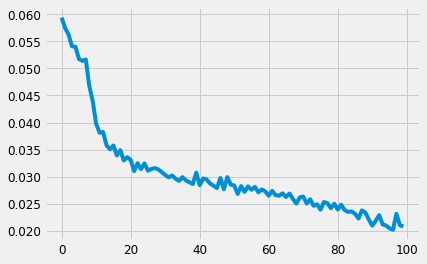

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Evaluate on Test Data

In [ ]:
first_eval_batch = scaled_train[-12:]

In [ ]:
first_eval_batch

array([[0.14285714],
       [0.28571429],
       [0.42857143],
       [0.        ],
       [0.        ],
       [0.57142857],
       [0.14285714],
       [0.28571429],
       [0.35714286],
       [0.14285714],
       [0.        ],
       [0.        ]])

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(first_eval_batch)

array([[0.44508064]], dtype=float32)

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
current_batch.shape

(1, 12, 1)

In [ ]:
current_batch

array([[[0.14285714],
        [0.28571429],
        [0.42857143],
        [0.        ],
        [0.        ],
        [0.57142857],
        [0.14285714],
        [0.28571429],
        [0.35714286],
        [0.14285714],
        [0.        ],
        [0.        ]]])

In [ ]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.28571429],
        [ 0.42857143],
        [ 0.        ],
        [ 0.        ],
        [ 0.57142857],
        [ 0.14285714],
        [ 0.28571429],
        [ 0.35714286],
        [ 0.14285714],
        [ 0.        ],
        [ 0.        ],
        [99.        ]]])

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

[array([0.44508064], dtype=float32),
 array([0.35923862], dtype=float32),
 array([0.36397785], dtype=float32),
 array([0.28232038], dtype=float32),
 array([0.26109236], dtype=float32),
 array([0.01639675], dtype=float32),
 array([0.02822142], dtype=float32),
 array([0.57647216], dtype=float32),
 array([0.30981827], dtype=float32),
 array([0.31014264], dtype=float32),
 array([0.32919866], dtype=float32),
 array([0.19892183], dtype=float32)]

In [ ]:
scaled_test

array([[0.64285714],
       [0.28571429],
       [0.07142857],
       [0.5       ],
       [0.28571429],
       [0.        ],
       [0.        ],
       [0.42857143],
       [0.14285714],
       [0.28571429],
       [0.07142857],
       [0.14285714]])

Inverse Transformation and Compares

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

array([[6.23112893],
       [5.02934074],
       [5.09568989],
       [3.95248532],
       [3.65529311],
       [0.22955444],
       [0.39509989],
       [8.07061028],
       [4.33745575],
       [4.34199691],
       [4.60878122],
       [2.78490561]])

In [ ]:
test

,Urgent Daily Demand,Predictions
361,9.0,6.718187
362,4.0,4.810862
363,1.0,4.753494
364,7.0,4.503133
365,4.0,3.781886
366,0.0,0.167457
367,0.0,-0.054284
368,6.0,7.251123
369,2.0,4.997864
370,4.0,4.789743


In [ ]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [ ]:
test

,Urgent Daily Demand,Predictions
361,9.0,6.231129
362,4.0,5.029341
363,1.0,5.095690
364,7.0,3.952485
365,4.0,3.655293
366,0.0,0.229554
367,0.0,0.395100
368,6.0,8.070610
369,2.0,4.337456
370,4.0,4.341997


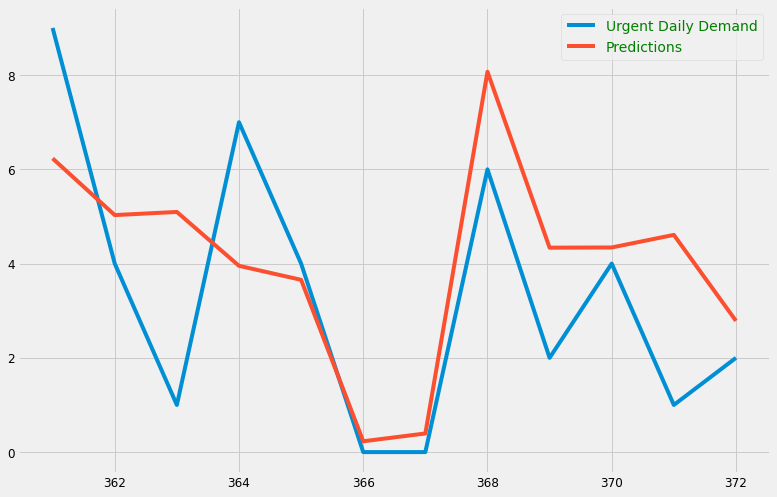

In [ ]:
test.plot(figsize=(12,8))

#Validation Dataset

In [ ]:
series = pd.read_csv('UrgentDemand.csv', index_col=0, header=0, parse_dates=True, squeeze=True)

In [ ]:
#split into a traiining and validation dataset
from pandas import read_csv
series = pd.read_csv('UrgentDemand.csv', index_col=0, header=0, parse_dates=True, squeeze=True)
split_point = len(series) - 7
dataset, validation = series[0:split_point], series[split_point:]

print('Dataset %d, validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 366, validation 7


#Split Dataset

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
#load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
#prepare data
X = series.values
X = X.astype('float32')
train_size = 300 
#int(len(X)*0.50)
train, test = X[0:train_size], X[train_size:]
#####
history = [x for x in train]


#Develop a SARIMA model

Autocorrelation

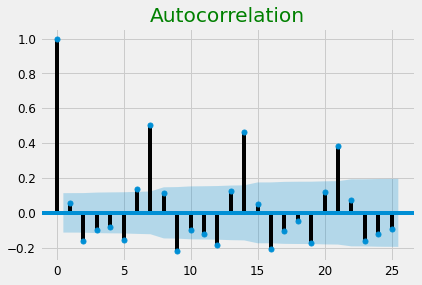

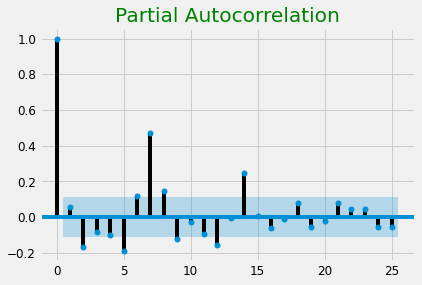

In [ ]:
plot_acf(train)
plot_pacf(train);



*   The ACF and PACF plots shows significant lags in 7,14,21 time steps which shows weekly seasonality
*   We takes the seasnal difference of data in the following:



In [ ]:
import numpy

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval):
	return yhat + history[-interval]

In [ ]:
X = series.values
daysinweek = 7
differenced = difference(X, daysinweek)

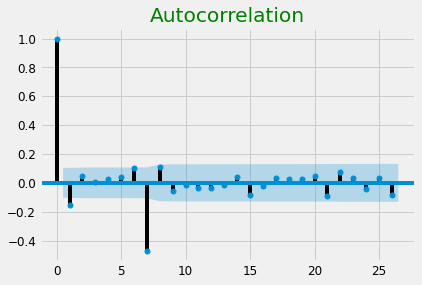

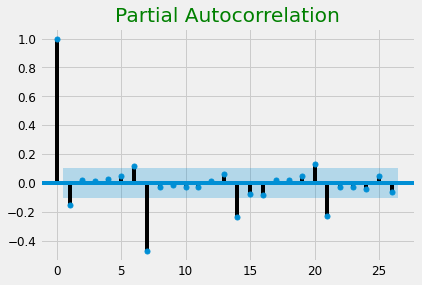

In [ ]:
plot_acf(differenced)
plot_pacf(differenced);



1.   ACF plot shows significant lags to 1 time step and 7 time steps
2.   PACF plot shows signiant lags at 1 time step and 7,14,21 time steps
3.   Therefore as start point we start with SARIMA (1,0,1)(3,1,1)[7]



#SARIMA configuration
A seasonal ARIMA model is classified as an "ARIMA(p,d,q)x(P,D,Q)" model, where:
(p,d,q) describes the non-seasonal part and (P,D,Q) describes the seasonal part.


*   **p** is the number of autoregressive term
*   **d** is the number of nonseasonal difference needed for stationarity
*   **q** is the number of lagged forecast errors in the prediction equation
*   **P** is the number of seasonal autoregressive term (SAR).
*   **D** is the number of seasonal differences.
*   **Q** is the number of seasonal moving average (SMA) terms.

In [ ]:
#evaluate manually configured ARIMA model
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
#walk forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):

  #predict
  model = SARIMAX(history, order = (1,0,1), seasonal_order=(3,1,1,7))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]

  

  predictions.append(yhat)

  #observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' %(yhat, obs))

#report performance
rmse = sqrt(mean_squared_error(test, predictions))

print('RMSE: %.3f' % rmse)


>Predicted=4.435, Expected=1.000
>Predicted=3.811, Expected=1.000
>Predicted=3.711, Expected=1.000
>Predicted=0.028, Expected=0.000
>Predicted=0.060, Expected=0.000
>Predicted=5.729, Expected=4.000
>Predicted=4.617, Expected=6.000
>Predicted=3.584, Expected=3.000
>Predicted=3.832, Expected=5.000
>Predicted=3.250, Expected=6.000
>Predicted=0.160, Expected=0.000
>Predicted=-0.056, Expected=0.000
>Predicted=6.588, Expected=0.000
>Predicted=4.757, Expected=9.000
>Predicted=3.690, Expected=3.000
>Predicted=4.779, Expected=10.000
>Predicted=3.373, Expected=3.000
>Predicted=0.752, Expected=2.000
>Predicted=-0.671, Expected=0.000
>Predicted=6.095, Expected=3.000
>Predicted=5.387, Expected=14.000
>Predicted=3.467, Expected=5.000
>Predicted=5.880, Expected=1.000
>Predicted=3.920, Expected=6.000
>Predicted=0.110, Expected=0.000
>Predicted=0.157, Expected=0.000
>Predicted=5.773, Expected=7.000
>Predicted=6.030, Expected=3.000
>Predicted=4.552, Expected=4.000
>Predicted=3.765, Expected=6.000
>Predi

predicted=4.435105, expected=1.000000
predicted=3.811153, expected=1.000000
predicted=3.711331, expected=1.000000
predicted=0.027920, expected=0.000000
predicted=0.059806, expected=0.000000
predicted=5.728987, expected=4.000000
predicted=4.616540, expected=6.000000
predicted=3.583567, expected=3.000000
predicted=3.831702, expected=5.000000
predicted=3.250484, expected=6.000000
predicted=0.160327, expected=0.000000
predicted=-0.056056, expected=0.000000
predicted=6.588163, expected=0.000000
predicted=4.756546, expected=9.000000
predicted=3.690260, expected=3.000000
predicted=4.779204, expected=10.000000
predicted=3.373357, expected=3.000000
predicted=0.751843, expected=2.000000
predicted=-0.670857, expected=0.000000
predicted=6.094885, expected=3.000000
predicted=5.386673, expected=14.000000
predicted=3.466512, expected=5.000000
predicted=5.879530, expected=1.000000
predicted=3.920417, expected=6.000000
predicted=0.109873, expected=0.000000
predicted=0.156670, expected=0.000000
predicte

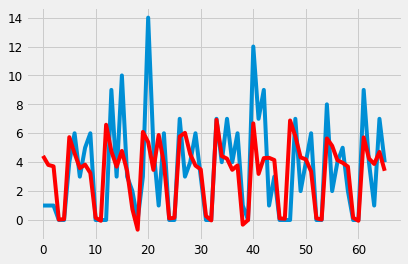

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = SARIMAX(history, order=(1,0,1),seasonal_order=(3,1,1,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append((yhat))
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
print('ARIMA(1,0,1)(3,1,1)[7] MAE Error: %.3f' %error1)
print('ARIMA(1,0,1)(3,1,1)[7] MSE Error: %.3f' %error2)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

# create a set of sarima configs to try


how to choose the range?

In [ ]:
def sarima_configs(seasonal=[7]):
	models = list()
	# define config lists
	p_params = [0, 1]
	d_params = [0, 1]
	q_params = [0, 1]
	P_params = [1, 2, 3]
	#D_params = [1]
	Q_params = [1, 2]
	#m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for P in P_params:
					#for D in D_params:
						for Q in Q_params:
							#for m in m_params:
								cfg = [(p,d,q), (P,1,Q,7)]
								models.append(cfg)
	return models

In [ ]:
sarima_configs(seasonal=[7])

[[(0, 0, 0), (1, 1, 1, 7)],
 [(0, 0, 0), (1, 1, 2, 7)],
 [(0, 0, 0), (2, 1, 1, 7)],
 [(0, 0, 0), (2, 1, 2, 7)],
 [(0, 0, 0), (3, 1, 1, 7)],
 [(0, 0, 0), (3, 1, 2, 7)],
 [(0, 0, 1), (1, 1, 1, 7)],
 [(0, 0, 1), (1, 1, 2, 7)],
 [(0, 0, 1), (2, 1, 1, 7)],
 [(0, 0, 1), (2, 1, 2, 7)],
 [(0, 0, 1), (3, 1, 1, 7)],
 [(0, 0, 1), (3, 1, 2, 7)],
 [(0, 1, 0), (1, 1, 1, 7)],
 [(0, 1, 0), (1, 1, 2, 7)],
 [(0, 1, 0), (2, 1, 1, 7)],
 [(0, 1, 0), (2, 1, 2, 7)],
 [(0, 1, 0), (3, 1, 1, 7)],
 [(0, 1, 0), (3, 1, 2, 7)],
 [(0, 1, 1), (1, 1, 1, 7)],
 [(0, 1, 1), (1, 1, 2, 7)],
 [(0, 1, 1), (2, 1, 1, 7)],
 [(0, 1, 1), (2, 1, 2, 7)],
 [(0, 1, 1), (3, 1, 1, 7)],
 [(0, 1, 1), (3, 1, 2, 7)],
 [(1, 0, 0), (1, 1, 1, 7)],
 [(1, 0, 0), (1, 1, 2, 7)],
 [(1, 0, 0), (2, 1, 1, 7)],
 [(1, 0, 0), (2, 1, 2, 7)],
 [(1, 0, 0), (3, 1, 1, 7)],
 [(1, 0, 0), (3, 1, 2, 7)],
 [(1, 0, 1), (1, 1, 1, 7)],
 [(1, 0, 1), (1, 1, 2, 7)],
 [(1, 0, 1), (2, 1, 1, 7)],
 [(1, 0, 1), (2, 1, 2, 7)],
 [(1, 0, 1), (3, 1, 1, 7)],
 [(1, 0, 1), (3, 1, 

# Grid search sarima hyperparameters

In [ ]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

One Step Sarima Forecast

In [ ]:
def sarima_forecast(history, config):
	order, sorder = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [ ]:
history = [x for x in train]

In [ ]:
config = [(1,1,2), (3,1,2,7)]

In [ ]:
sarima_forecast(history,config)

3.5130604624450115

In [ ]:
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [ ]:
cfg = [(1,1,2), (3,1,2,7)]
n_test = 300
walk_forward_validation(data, n_test, cfg)

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
def sarima_configs(seasonal=[7]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	#t_params = ['n','c','t','ct']
	P_params = [1, 2]
	D_params = [1]
  #D = 1
	Q_params = [1, 2]
	m_params = seasonal
  #m = 7
	# create config instances
	for p in p_params:
		#for d in d_params:
			for q in q_params:
				#for t in t_params:
					#for P in P_params:
						#for D in D_params:
							#for Q in Q_params:
								#for m in m_params:
									cfg = [(p,0,q), (1,1,1,7)]
									models.append(cfg)
	return models

In [ ]:
sarima_configs(seasonal=[7])

[[(0, 0, 0), (1, 1, 1, 7)],
 [(0, 0, 1), (1, 1, 1, 7)],
 [(0, 0, 2), (1, 1, 1, 7)],
 [(1, 0, 0), (1, 1, 1, 7)],
 [(1, 0, 1), (1, 1, 1, 7)],
 [(1, 0, 2), (1, 1, 1, 7)],
 [(2, 0, 0), (1, 1, 1, 7)],
 [(2, 0, 1), (1, 1, 1, 7)],
 [(2, 0, 2), (1, 1, 1, 7)]]

In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [ ]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [ ]:
def sarima_forecast(history, config):
	order, sorder = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [ ]:
data = X
n_test = 300
# model configs
cfg_list = sarima_configs(seasonal=[7])
#grid search config


In [ ]:
data

In [ ]:
cfg_list

In [ ]:
scores = grid_search(data, cfg_list, n_test, parallel=True)

 > Model[[(0, 0, 0), (1, 1, 1, 7)]] 2.461
 > Model[[(0, 0, 0), (1, 1, 2, 7)]] 2.473
 > Model[[(0, 0, 0), (2, 1, 1, 7)]] 2.451
 > Model[[(0, 0, 0), (2, 1, 2, 7)]] 2.472
 > Model[[(0, 0, 0), (3, 1, 1, 7)]] 2.558
 > Model[[(0, 0, 1), (1, 1, 1, 7)]] 2.471
 > Model[[(0, 0, 1), (1, 1, 2, 7)]] 2.459
 > Model[[(0, 0, 0), (3, 1, 2, 7)]] 2.583
 > Model[[(0, 0, 1), (2, 1, 1, 7)]] 2.469
 > Model[[(0, 0, 1), (2, 1, 2, 7)]] 2.494
 > Model[[(0, 0, 1), (3, 1, 1, 7)]] 2.588
 > Model[[(0, 1, 0), (1, 1, 1, 7)]] 3.669
 > Model[[(0, 1, 0), (1, 1, 2, 7)]] 3.584
 > Model[[(0, 0, 1), (3, 1, 2, 7)]] 2.626
 > Model[[(0, 1, 0), (2, 1, 1, 7)]] 3.627
 > Model[[(0, 1, 0), (2, 1, 2, 7)]] 3.629
 > Model[[(0, 1, 0), (3, 1, 1, 7)]] 3.771
 > Model[[(0, 1, 1), (1, 1, 1, 7)]] 2.545
 > Model[[(0, 1, 0), (3, 1, 2, 7)]] 3.731
 > Model[[(0, 1, 1), (1, 1, 2, 7)]] 2.493
 > Model[[(0, 1, 1), (2, 1, 2, 7)]] 2.534
 > Model[[(0, 1, 1), (2, 1, 1, 7)]] 2.498
 > Model[[(0, 1, 1), (3, 1, 1, 7)]] 2.610
 > Model[[(1, 0, 0), (1, 1, 1, 7)]

In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

[(0, 0, 0), (2, 1, 1, 7)] 2.4506042474751224
[(1, 0, 0), (2, 1, 1, 7)] 2.457701332829215
[(0, 0, 1), (1, 1, 2, 7)] 2.459421732473649


#root mean squared error or rmse

In [ ]:
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

#split a univariate dataset into train/test sets

In [ ]:
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data

# create a set of sarima configs to try

---



In [ ]:
# grid search
scores = grid_search(data, cfg_list, n_test)

In [ ]:
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

[(2, 0, 2), (0, 0, 0, 0), 'c'] 3.047914987422693
[(2, 0, 1), (0, 0, 0, 0), 'c'] 3.175575920633799
[(1, 0, 2), (0, 0, 0, 0), 'c'] 3.1815041414287935


In [ ]:
# grid search
scores = grid_search(data, cfg_list, n_test)

 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.461
 > Model[[(0, 0, 1), (1, 1, 1, 7), 'n']] 2.471
 > Model[[(1, 0, 0), (1, 1, 1, 7), 'n']] 2.464
 > Model[[(0, 0, 2), (1, 1, 1, 7), 'n']] 2.473
 > Model[[(1, 0, 1), (1, 1, 1, 7), 'n']] 2.484
 > Model[[(2, 0, 0), (1, 1, 1, 7), 'n']] 2.471
 > Model[[(1, 0, 2), (1, 1, 1, 7), 'n']] 2.466
 > Model[[(2, 0, 1), (1, 1, 1, 7), 'n']] 2.490
 > Model[[(2, 0, 2), (1, 1, 1, 7), 'n']] 2.478


In [ ]:
# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

[(0, 0, 0), (1, 1, 1, 7), 'n'] 2.4614437755448484
[(1, 0, 0), (1, 1, 1, 7), 'n'] 2.4640282189534757
[(1, 0, 2), (1, 1, 1, 7), 'n'] 2.46628752295476


In [ ]:
train, test = train_test_split(data, n_test)

In [ ]:
train

array([ 1.,  0.,  0.,  0.,  0.,  4.,  3.,  3.,  1.,  0.,  0.,  0.,  7.,
        3.,  0.,  4.,  0.,  0.,  7.,  4.,  2.,  4.,  2.,  0.,  0., 14.,
        1.,  5.,  5.,  2.,  0.,  0.,  7.,  3.,  0.,  6.,  5.,  0.,  0.,
       11.,  6.,  0.,  5.,  6.,  0.,  0.,  0.,  7.,  6.,  8.,  4.,  0.,
        0., 13.,  4.,  6.,  6.,  6.,  0.,  0.,  6.,  9.,  9.,  5.,  4.,
        0.], dtype=float32)

In [ ]:
def retrive_cum_rmse(test,predict):
    """Reterive the cumulative Root Mean Square Error between a test dataset and real values.
    """
    cum_err = np.cumsum(np.sqrt((test - predict)**2))
    for i in range(len(cum_err)):
        cum_err[i] /= i+1
    return cum_err

In [ ]:
Sarerr = retrive_cum_rmse(test,predictions)

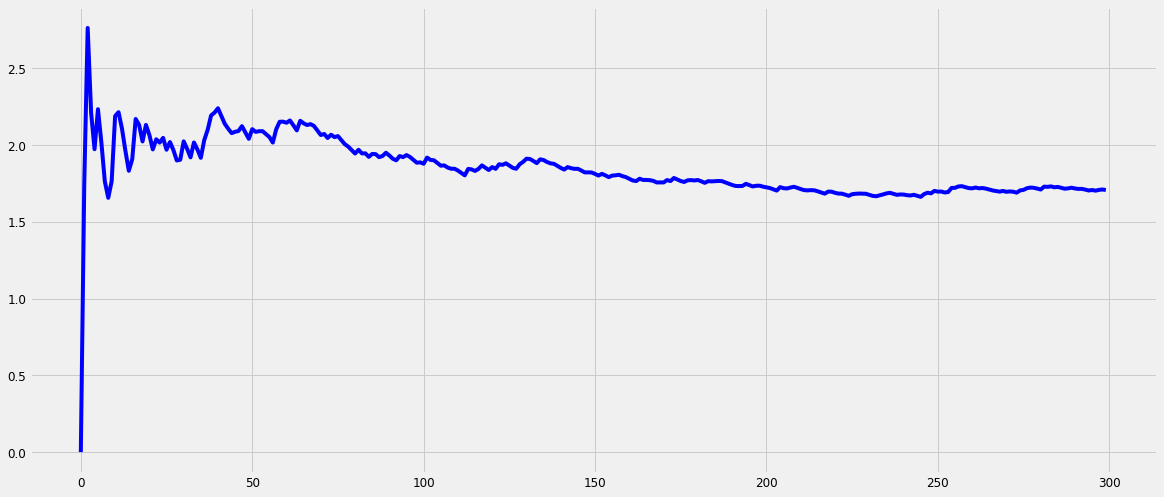

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(Sarerr, 'b', label='Sarima')

In [ ]:
sqrt(6.074)

2.46454864021792

In [ ]:
# grid search
scores = grid_search(data, cfg_list, n_test)

 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.461
 > Model[[(0, 0, 0), (1, 1, 2, 7), 'n']] 2.473
 > Model[[(0, 0, 0), (2, 1, 1, 7), 'n']] 2.451
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'c']] 2.509
 > Model[[(0, 0, 0), (2, 1, 2, 7), 'n']] 2.472
 > Model[[(0, 0, 0), (1, 1, 2, 7), 'c']] 2.520
 > Model[[(0, 0, 0), (2, 1, 1, 7), 'c']] 2.494
 > Model[[(0, 0, 0), (1, 1, 1, 7), 't']] 2.561
 > Model[[(0, 0, 0), (2, 1, 2, 7), 'c']] 2.501


KeyboardInterrupt: ignored

In [ ]:
# grid search
scores = grid_search(data, cfg_list, n_test)

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 4.651
 > Model[[(0, 0, 0), (0, 0, 0, 7), 'n']] 4.651
 > Model[[(0, 0, 0), (0, 0, 1, 7), 'n']] 3.785
 > Model[[(0, 0, 0), (0, 1, 0, 7), 'n']] 3.250
 > Model[[(0, 0, 0), (0, 0, 2, 7), 'n']] 3.615
 > Model[[(0, 0, 0), (0, 1, 1, 7), 'n']] 2.413
 > Model[[(0, 0, 0), (1, 0, 0, 7), 'n']] 3.052
 > Model[[(0, 0, 0), (1, 0, 1, 7), 'n']] 2.473
 > Model[[(0, 0, 0), (0, 1, 2, 7), 'n']] 2.420
 > Model[[(0, 0, 0), (1, 1, 0, 7), 'n']] 2.904
 > Model[[(0, 0, 0), (1, 1, 1, 7), 'n']] 2.461
 > Model[[(0, 0, 0), (1, 0, 2, 7), 'n']] 2.498
 > Model[[(0, 0, 0), (2, 0, 0, 7), 'n']] 2.838
 > Model[[(0, 0, 0), (2, 0, 1, 7), 'n']] 2.511
 > Model[[(0, 0, 0), (1, 1, 2, 7), 'n']] 2.473
 > Model[[(0, 0, 0), (2, 1, 0, 7), 'n']] 2.821
 > Model[[(0, 0, 0), (2, 0, 2, 7), 'n']] 2.545
 > Model[[(0, 0, 0), (2, 1, 1, 7), 'n']] 2.451
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 3.219
 > Model[[(0, 0, 0), (0, 0, 0, 7), 'c']] 3.219
 > Model[[(0, 0, 0), (0, 0, 1, 7), 'c']] 2.967
 > Model[[(0,

KeyboardInterrupt: ignored

In [ ]:
# define dataset
	data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
	print(data)
	# data split
	n_test = 4
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

In [ ]:
#walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
  #predict
  yhat = history[-1]
  predictions.append(yhat)

  #observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

#report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

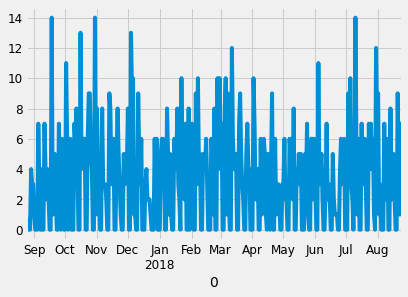

In [ ]:
series.plot()
pyplot.show()

#Density Plot

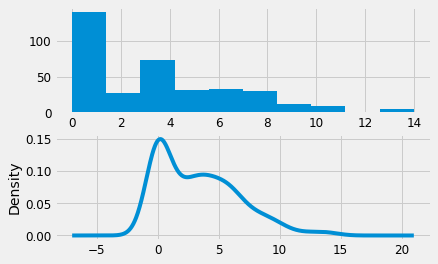

In [ ]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

#Manually Configured ARIMA

In [ ]:
#Statistical test for the stationaity of the time series
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller

#Create a differenced time series
def difference(dataset):
  diff = list()
  for i in range(7,len(dataset)):
    value = dataset[i] - dataset[i-7]
    diff.append(value)

  return Series(diff)

In [ ]:
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
#difference data
stationary = difference(X)
stationary.index = series.index[7:]

#check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values')

for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

#save
stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -7.158606
p-value: 0.000000
Critical Values
	1%: -3.450
	5%: -2.870
	10%: -2.571


In [ ]:
#evaluate manually configured ARIMA model
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
#walk forward validation
history = [x for x in stationary]
predictions = list()
for i in range(len(test)):

  #predict
  model = SARIMAX(history, order = (1,0,1), seasonal_order=(2,1,0,7))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]

  #invert difference values
  def inverse_difference(history, yhat, interval=7):
    return yhat+ history[-interval]
  
  yhat2 = inverse_difference(history, yhat, interval=7)

  predictions.append(yhat)

  #observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' %(yhat, obs))

#report performance
rmse = sqrt(mean_squared_error(test, predictions))

print('RMSE: %.3f' % rmse)


#Split Dataset

In [ ]:
# split the dataset
from pandas import read_csv

split_point = len(HFAblankOut) - 7
dataset, validation = HFAblankOut[0:split_point], HFAblankOut[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', index=False)
validation.to_csv('validation.csv', index=False)

Dataset 366, Validation 7


#Develop Model

In [ ]:
import numpy

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval):
	return yhat + history[-interval]

In [ ]:
X = series.values
daysinweek = 7
differenced = difference(X, daysinweek)

In [ ]:
plt.plot(differenced)

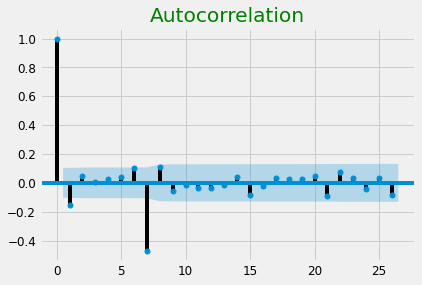

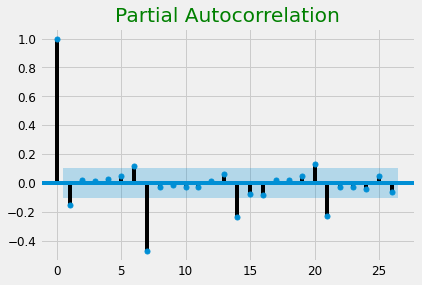

In [ ]:
plot_acf(differenced)
plot_pacf(differenced);

In [ ]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
#series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(differenced, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=10.368
ARIMA(0, 0, 1) MSE=10.127
ARIMA(0, 0, 2) MSE=10.105
ARIMA(0, 1, 0) MSE=24.218
ARIMA(0, 1, 1) MSE=10.482
ARIMA(0, 1, 2) MSE=10.257
ARIMA(0, 2, 0) MSE=77.498
ARIMA(0, 2, 1) MSE=24.363
ARIMA(0, 2, 2) MSE=10.568
ARIMA(1, 0, 0) MSE=10.095
ARIMA(1, 0, 1) MSE=10.431
ARIMA(1, 0, 2) MSE=10.255
ARIMA(1, 1, 0) MSE=15.568
ARIMA(1, 1, 1) MSE=10.226
ARIMA(1, 1, 2) MSE=10.461
ARIMA(1, 2, 0) MSE=38.007
ARIMA(2, 0, 0) MSE=10.123
ARIMA(2, 0, 1) MSE=10.241
ARIMA(2, 1, 0) MSE=12.832
ARIMA(2, 1, 1) MSE=10.251
ARIMA(2, 1, 2) MSE=10.382
ARIMA(2, 2, 0) MSE=24.473
ARIMA(4, 0, 0) MSE=10.275
ARIMA(4, 0, 1) MSE=10.497
ARIMA(4, 0, 2) MSE=9.732
ARIMA(4, 1, 0) MSE=12.445
ARIMA(4, 1, 1) MSE=11.161
ARIMA(4, 2, 0) MSE=20.290
ARIMA(4, 2, 1) MSE=12.552
ARIMA(4, 2, 2) MSE=12.349
Best ARIMA(4, 0, 2) MSE=9.732


grid search ARIMA hyperparameter

In [ ]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	#train_size = int(len(X) * 0.66)
	#train, test = X[0:train_size], X[train_size:]
	#history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(differenced, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		differenced.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(validation, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(differenced, p_values, d_values, q_values):
	differenced = differenced.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(differenced, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
#def parser(x):
	#return datetime.strptime('190'+x, '%Y-%m')
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(differenced, p_values, d_values, q_values)

Best ARIMANone MSE=inf


The plot shows there is a weekly seasonality

# Augmented Dickey-Fuller Test to check if the time series is stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(HFAblankOut['Blank Daily Demand'],title='')

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.302608
p-value                   0.000440
# lags used              13.000000
# observations          359.000000
critical value (1%)      -3.448697
critical value (5%)      -2.869625
critical value (10%)     -2.571077
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# Split the data into train test sets

In [ ]:
len(HFAblankOut)

373

In [ ]:
train1 = HFAblankOut.iloc[:300]
test1 = HFAblankOut.iloc[300:]

In [ ]:
train

In [ ]:
HFAblankOut

In [ ]:
HFAblank1 = HFAblankOut[['Blank Daily Demand']]
HFAblank1 = HFAblank1.squeeze('columns')
X = HFAblank1.values
train = X[:300]
test = X[300:]
history = [x for x in train]

# Autocorrelation
we can utilize sample PACF (partial auto correlation) to get the AR order p. If the PACF cuts off after some lags, that number is the order of AR.

We can determine the MA order q by looking at the sample ACF (auto correlation). If the ACF cuts off after some lags, that number is the order of MA.


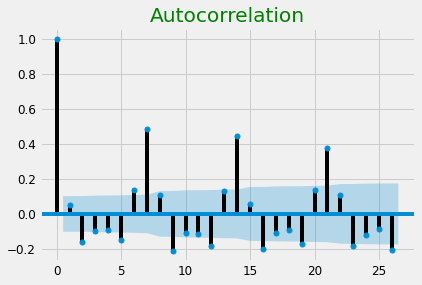

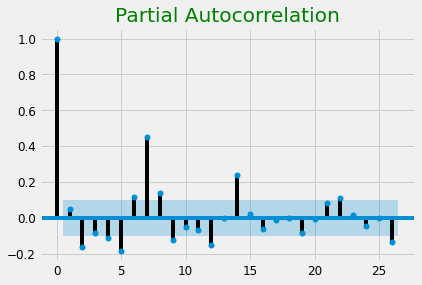

In [ ]:
#Finding the order of p and q in ARIMA model
plot_acf(HFAblankOut['Blank Daily Demand'])
plot_pacf(HFAblankOut['Blank Daily Demand']);

# Fit stepwise auto-ARIMA

In [ ]:
smodel = pmdarima.auto_arima(train1['Blank Daily Demand'], start_p=2, start_q=2,test='adf',max_p=5, max_q=5, m=7,start_P=0, seasonal=True,d=None, D=1, trace=True,error_action='ignore', suppress_warnings=True, stepwise=True)
smodel.summary()
#auto_arima(train['Blank Daily Demand'],seasonal=True,m=7).summary()

NameError: ignored

In [ ]:
model = SARIMAX(train1['Blank Daily Demand'],order=(1,0,0),seasonal_order=(2,1,0,7),enforce_invertibility=False)
#model = SARIMAX(train1['Blank Daily Demand'],order=(1,0,0),seasonal_order=(2,1,3,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(3,0,3),seasonal_order=(2,0,3,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(3,0,3),seasonal_order=(2,1,3,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(3,0,0),seasonal_order=(1,1,2,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(3,0,3),seasonal_order=(2,1,3,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(1,0,0),seasonal_order=(2,1,1,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(1,0,1),seasonal_order=(2,1,2,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(1,0,0),seasonal_order=(2,1,2,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(2,0,0),seasonal_order=(2,1,2,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(1,0,0),seasonal_order=(2,1,0,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(0,1,2),seasonal_order=(2,0,2,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(1,0,2),seasonal_order=(3,1,1,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(3,1,3),seasonal_order=(2,0,3,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(2,1,2),seasonal_order=(4,0,2,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(1,0,0),seasonal_order=(2,1,0,7),enforce_invertibility=False)
#model = SARIMAX(train['Blank Daily Demand'],order=(5,1,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
mm = model.fit()
mm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                Blank Daily Demand   No. Observations:                  300
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 7)   Log Likelihood                -713.920
Date:                           Fri, 06 Nov 2020   AIC                           1435.839
Time:                                   18:52:53   BIC                           1450.560
Sample:                               08-24-2017   HQIC                          1441.735
                                    - 06-19-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1138      0.064     -1.778      0.075      -0.239       0.012
ar.S.L7       -0.5568      0.043    -12.963      0.000      -0.641      -0.473
ar.S.L14      -0.2209      0.042     -5.231      0.000      -0.304      -0.138
sigma2         7.5935      0.479     15.846      0.000       6.654       8.533
===================================================================================
Ljung-Box (Q):                       53.23   Jarque-Bera (JB):                32.76
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Diagnostic test for the selected model

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1138      0.064     -1.778      0.075      -0.239       0.012
ar.S.L7       -0.5568      0.043    -12.963      0.000      -0.641      -0.473
ar.S.L14      -0.2209      0.042     -5.231      0.000      -0.304      -0.138
sigma2         7.5935      0.479     15.846      0.000       6.654       8.533


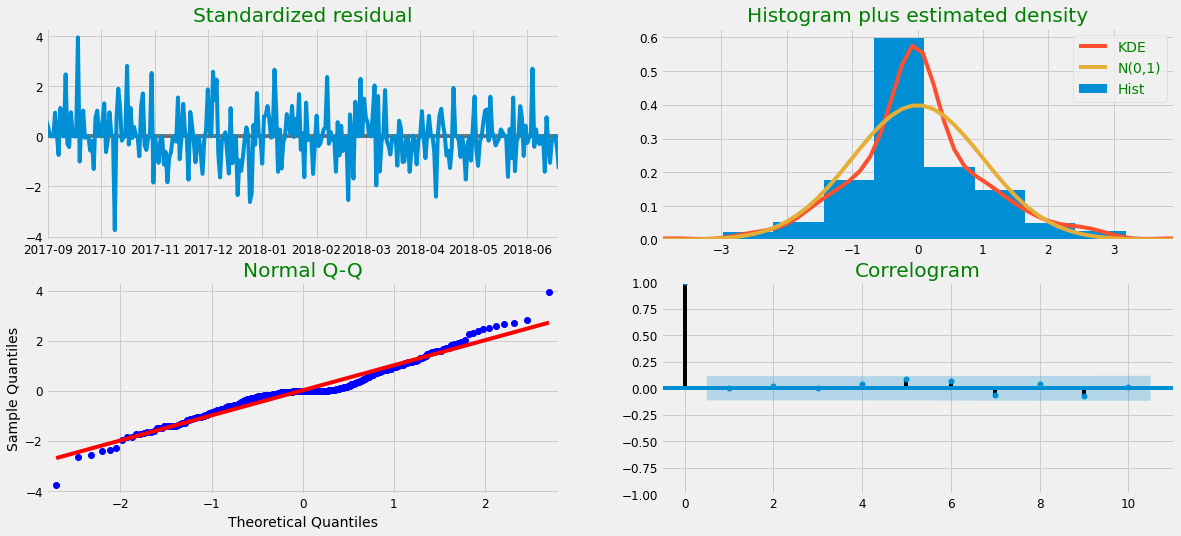

In [ ]:
#history = [x for x in train]
#mod = SARIMAX(train['Blank Daily Demand'],order=(3,0,0),seasonal_order=(1,1,2,7),enforce_invertibility=False)
#mod = SARIMAX(train1['Blank Daily Demand'],order=(3,0,3),seasonal_order=(2,1,3,7),enforce_invertibility=False)
mod = SARIMAX(train1['Blank Daily Demand'],order=(1,0,0),seasonal_order=(2,1,0,7),enforce_invertibility=False)
results = mod.fit(disp=0)
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(18, 8))
plt.show()

# Evaluate the Model

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
  #model = SARIMAX(history, order=(1,0,0),seasonal_order=(2,1,0,7))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append((yhat))
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % ((yhat), (obs)))
error1 = mean_absolute_error((test), (predictions))
error2 = mean_squared_error((test), (predictions))
print('ARIMA(1,0,1)(2,1,0)[7] MAE Error: %.3f' %error1)
print('ARIMA(1,0,1)(2,1,0)[7] MSE Error: %.3f' %error2)
# plot
pyplot.plot((test))
pyplot.plot(predictions, color='red')
pyplot.show()

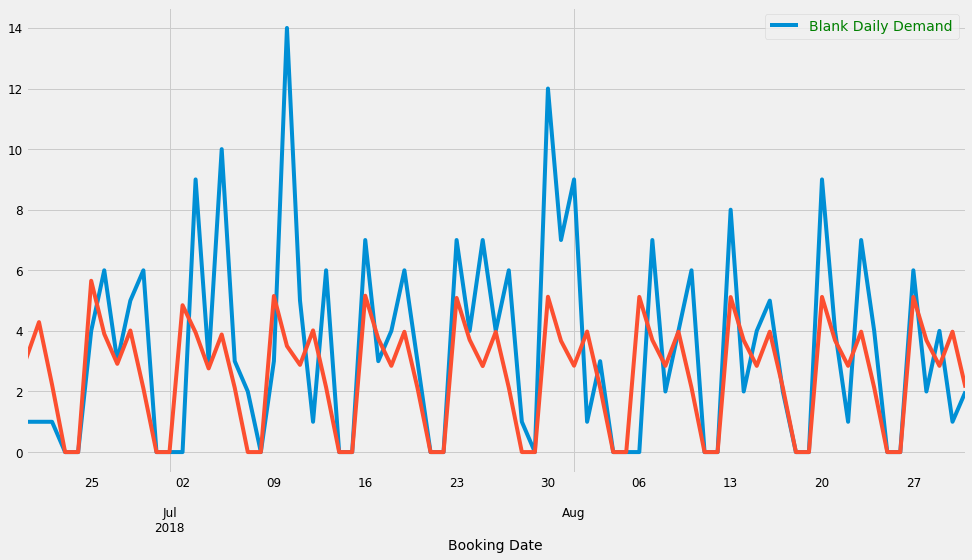

In [ ]:

start = len(train1)
end = len(train1) + len(test1) - 1
predictions = mm.predict(start,end).rename('Blank SARIMA Model')
test1['Blank Daily Demand'].plot(legend=True,figsize=(15,8))
predictions.plot();


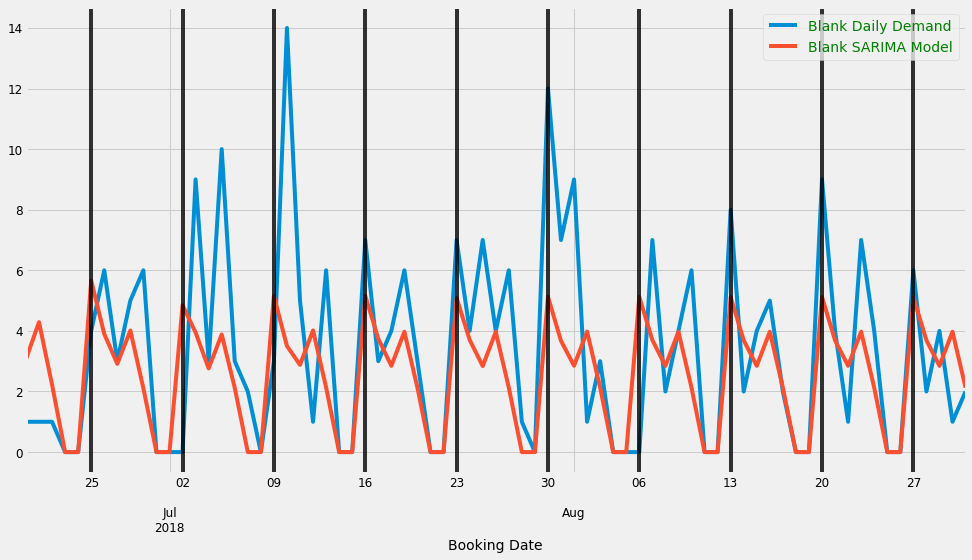

In [ ]:
ax = test1['Blank Daily Demand'].plot(legend=True,figsize=(15,8))
predictions.plot(legend=True)

for day in HFAblankOut.query('Monday ==1').index:
  ax.axvline(x=day, color='black',alpha=0.8);

#SARIMAX

In [ ]:
auto_arima(train1['Blank Daily Demand'],exogenous=train1[['Tuesday']],seasonal=True,m=7).summary()

Train SARIMAX model

In [ ]:
model2 = SARIMAX(train1['Blank Daily Demand'],exog=train1[['Tuesday']],order=(1,0,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)

In [ ]:
result2 = model2.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
predictions2 = result2.predict(start,end,exog=test1[['Monday']]).rename('SARIMAX with Exog')

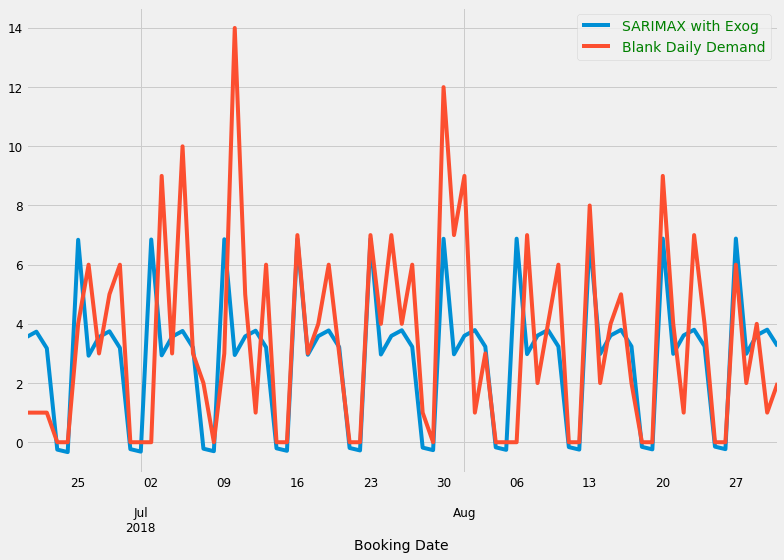

In [ ]:
predictions2.plot(figsize=(12,8),legend=True)
test1['Blank Daily Demand'].plot(legend=True)

In [ ]:
SARIMA
print(mean_absolute_error((test1['Blank Daily Demand']), (predictions)))
print(mean_squared_error((test1['Blank Daily Demand']),(predictions)))

1.8085701397002956
7.384082461779851


In [ ]:
SARIMAX
print(mean_absolute_error((test1['Blank Daily Demand']), (predictions2)))
print(mean_squared_error((test1['Blank Daily Demand']),(predictions2)))


1.809442649273007
7.529232675914794


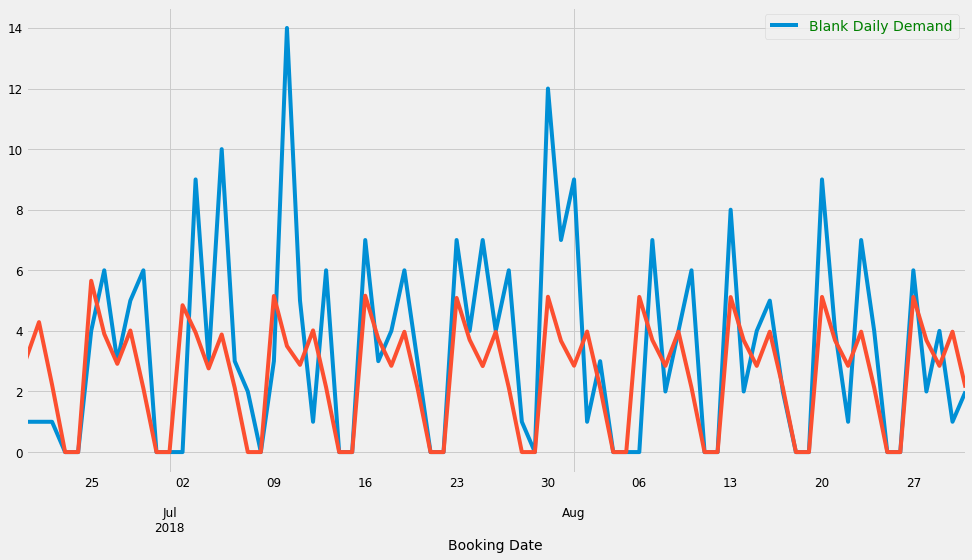

In [ ]:
start = len(train1)
end = len(train1) + len(test1) - 1
predictions = mm.predict(start,end).rename('Blank SARIMA Model')
test1['Blank Daily Demand'].plot(legend=True,figsize=(15,8))
predictions.plot();

Facebook Prophet